In [1]:
! pip install qiskit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator
from qiskit.extensions import RXGate, RYGate, RZGate   

In [3]:
class Agent:
    def __init__(self, n_anctions, epsilon_0=0.1, e_decay=1):
        self.epsilon_0 = epsilon_0
        self.e_decay = e_decay
        self.indices = np.arange(n_anctions)

    def reset(self):
        self.q_estimation = np.zeros(len(self.indices))
        self.epsilon = self.epsilon_0
        self.action_count = np.zeros(len(self.indices))
        return np.random.choice(self.indices)

    def act(self):
        self.epsilon *= self.e_decay
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)           
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action, reward):
        self.action_count[action] += 1
        self.step_size = 1 / self.action_count[action]        
        self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        return self.q_estimation

In [4]:
def crear_circuito(tipo, quantum_dict):
    # if tipo not in quantum_dict.keys():
    n_players = len(tipo)
    I = np.array([[1, 0],
                  [0, 1]])
    X = np.array([[0, 1],
                  [1, 0]])
    I_f = I
    X_f = X
    for i in range(n_players-1):
        I_f = np.kron(I_f, I)
        X_f = np.kron(X_f, X)
    
    J = Operator(1 / np.sqrt(2) * (I_f + 1j * X_f))    
    J_dg = J.adjoint()
    circ = QuantumCircuit(n_players, n_players)
    circ.append(J, range(n_players))    
    for i in range(n_players):        
        circ.append(RXGate(tipo[i][0]),[i])
        circ.append(RYGate(tipo[i][1]),[i])
        circ.append(RZGate(tipo[i][2]),[i])     
    circ.append(J_dg, range(n_players))
    #quantum_dict[tipo] = circ
    #return quantum_dict[tipo]    
    return circ

def reward_game(rotat, quantum_dict):
    circ = crear_circuito(rotat, quantum_dict)
    circ.measure(range(len(rotat)), range(len(rotat)))  
    backend = Aer.get_backend('qasm_simulator')
    measurement = execute(circ, backend=backend, shots=1).result().get_counts(circ)    
    output = list(measurement.keys())[0]
    # Minority game variant (only 1s)
    reward = [0 for i in range(len(output))]
    if (output.count('1') == 1):
        reward[output.find('1')] = 10
    return reward   

def game(all_actions, actions, quantum_dict):
    rotat = np.zeros([len(actions), 3])
    for idx, action_i in enumerate(actions):
        rotat[idx] =  all_actions[action_i]      
    reward = reward_game(rotat, quantum_dict)      
    return reward

In [5]:
def simulate(agents, time, all_actions): 
    q_table =     [0 for i in range(len(agents))] 
    actions =     [0 for i in range(len(agents))] 
    actions_max = [0 for i in range(len(agents))] 
    reward =      [0 for i in range(len(agents))]
    reward_max =  [0 for i in range(len(agents))] 
    rewards =     np.zeros((len(agents), time))
    rewards_avg = np.zeros(rewards.shape) 
    quantum_dict = {}
    for t in trange(time):    
        for i, agent in enumerate(agents):
            if t==0:
                actions[i] = agent.reset()
            else:
                rewards[i, t] = reward[i]  
                rewards_avg[i, t] = np.mean(rewards[i,0:t+1])   
                if reward[i] > reward_max[i]:
                    actions_max[i] = actions[i] 
                q_table[i] = agent.step(actions[i], reward[i])
                actions[i] = agent.act()
        reward = game(all_actions, actions, quantum_dict)
    return rewards, rewards_avg, actions_max, q_table

In [6]:
players = 2
time = 100000
"""epsilon_0 = 0.99
epsilon_f = 0.01
e_decay = np.power(epsilon_f/epsilon_0, 1/time)"""

'epsilon_0 = 0.99\nepsilon_f = 0.01\ne_decay = np.power(epsilon_f/epsilon_0, 1/time)'

In [7]:
N_SIZE = 3
angulos = np.arange(0, 2 * np.pi, 2 * np.pi / np.power(2, N_SIZE))
all_actions = [(rx,ry,rz) for rx in angulos for ry in angulos for rz in angulos]
agents = []
for i in range(players):
    agents.append(Agent(n_anctions=len(all_actions)))  
rewards , rewards_avg, actions_max, q_table = simulate(agents, time, all_actions)

100%|██████████| 100000/100000 [26:43<00:00, 62.38it/s]


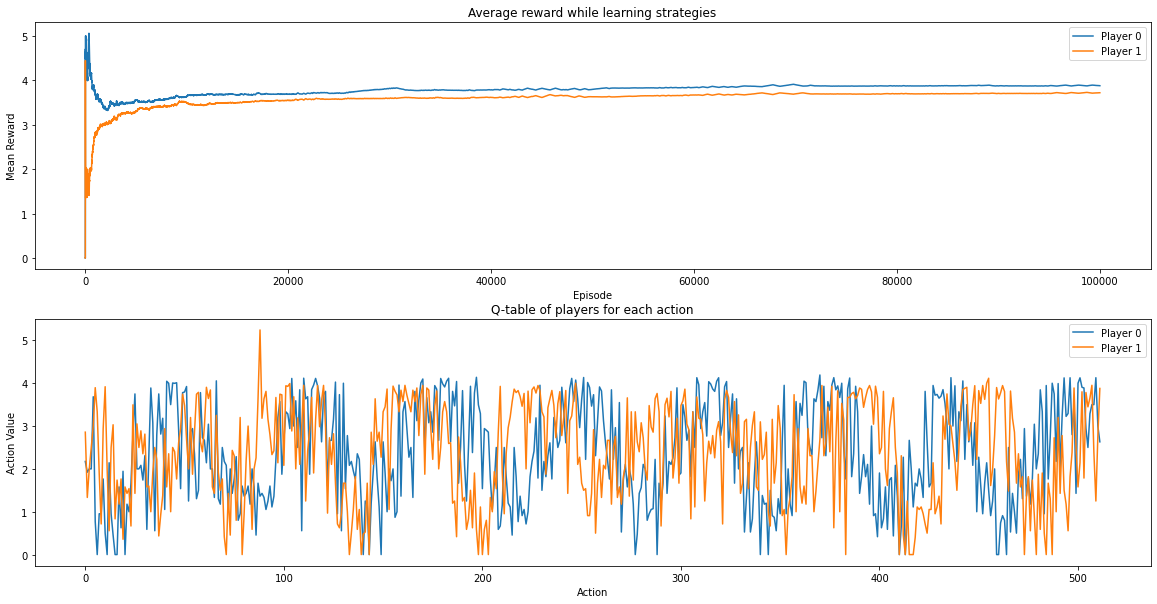

In [8]:
fig0, axs = plt.subplots(2, 1, figsize=(20,10))
for i in range(players):
    axs[0].plot(rewards_avg[i], label="Player {}".format(i))
    axs[1].plot(q_table[i], label="Player {}".format(i))    
axs[0].set_title("Average reward while learning strategies")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Mean Reward")
axs[0].legend(loc='upper right')
axs[1].set_title("Q-table of players for each action")
axs[1].set_ylabel("Action Value")
axs[1].set_xlabel("Action")
axs[1].legend(loc='upper right')
plt.show()

In [9]:
def reward_game_class(prob):
    seed = np.random.uniform()
    outc = np.where(seed>prob, 0, 1)
    rewa = [0 for i in range(len(outc))]
    if (np.count_nonzero(outc == 1) == 1):
        rewa = np.where(outc == 1, 10, 0)         # non-cooperative
        #rewa = [1 for i in range(len(outc))]     # cooperative
    return rewa

def game_class(all_actions, actions):
    prob = np.zeros([len(actions)])
    for idx, action_i in enumerate(actions):
        prob[idx] =  all_actions[action_i]      
    reward = reward_game_class(prob)      
    return reward  

In [10]:
def simulate_class(agents, time, all_actions): 
    q_table =     [0 for i in range(len(agents))] 
    actions =     [0 for i in range(len(agents))] 
    actions_max = [0 for i in range(len(agents))] 
    reward =      [0 for i in range(len(agents))]
    reward_max =  [0 for i in range(len(agents))] 
    
    rewards =     np.zeros((len(agents), time))
    rewards_avg = np.zeros(rewards.shape) 

    for t in trange(time):    
        for i, agent in enumerate(agents):
            if t==0:
                actions[i] = agent.reset()
            else:
                rewards[i, t] = reward[i]  
                rewards_avg[i, t] = np.mean(rewards[i,0:t+1])   
                if reward[i] > reward_max[i]:
                    actions_max[i] = actions[i] 
                q_table[i] = agent.step(actions[i], reward[i])
                actions[i] = agent.act()
        reward = game_class(all_actions, actions)
    return rewards, rewards_avg, actions_max, q_table      

In [11]:
all_actions_class = np.arange(0,1,0.01)
agents_class = []
for i in range(players):
    agents_class.append(Agent(n_anctions=len(all_actions_class)))  
rewards_class , rewards_avg_class, actions_max_class, q_table_class = simulate_class(agents_class, time, all_actions_class) 

100%|██████████| 100000/100000 [00:29<00:00, 3419.43it/s]


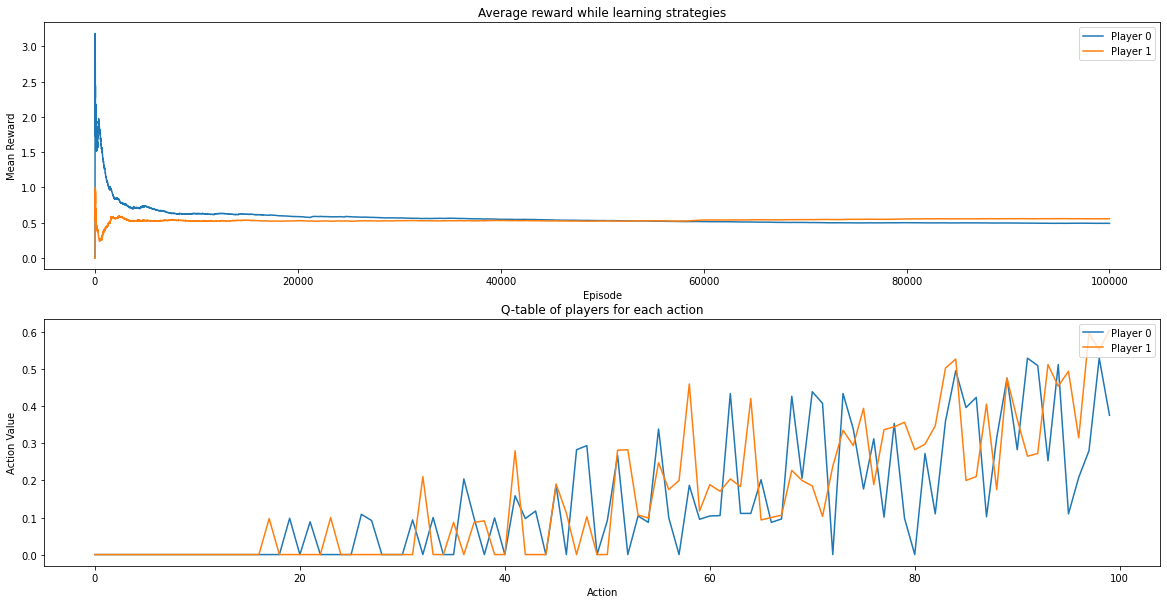

In [12]:
fig0, axs = plt.subplots(2, 1, figsize=(20,10))
for i in range(players):
    axs[0].plot(rewards_avg_class[i], label="Player {}".format(i))
    axs[1].plot(q_table_class[i], label="Player {}".format(i))    
axs[0].set_title("Average reward while learning strategies")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Mean Reward")
axs[0].legend(loc='upper right')
axs[1].set_title("Q-table of players for each action")
axs[1].set_ylabel("Action Value")
axs[1].set_xlabel("Action")
axs[1].legend(loc='upper right')
plt.show()

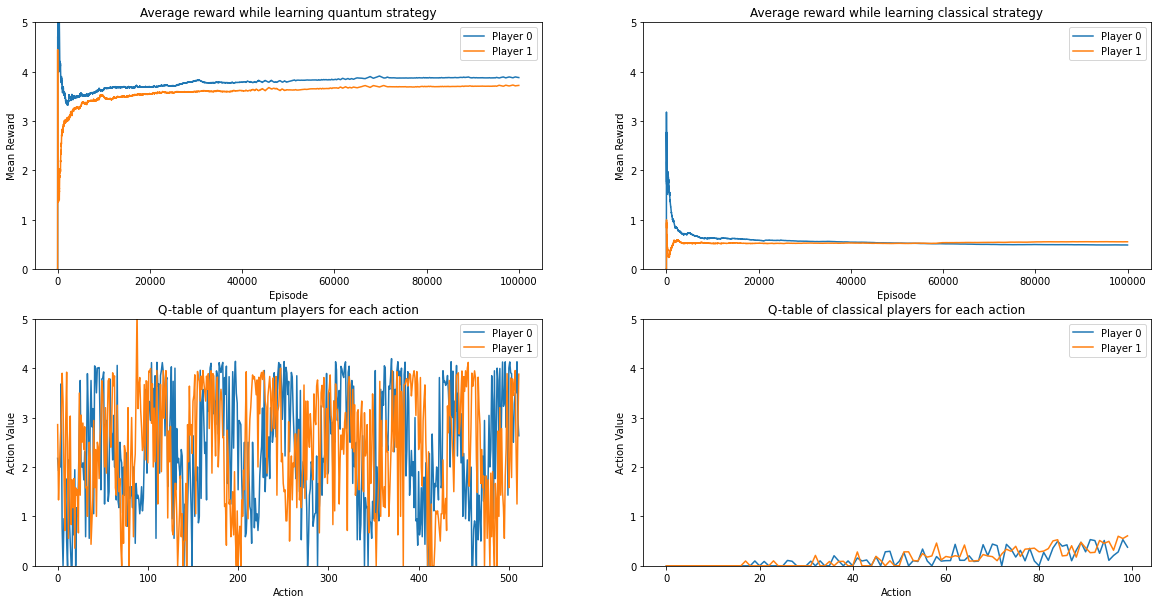

In [13]:
fig0, axs = plt.subplots(2, 2, figsize=(20,10))
for i in range(players):
    axs[0,0].plot(rewards_avg[i], label="Player {}".format(i))
    axs[0,1].plot(rewards_avg_class[i], label="Player {}".format(i))    
    axs[1,0].plot(q_table[i], label="Player {}".format(i))
    axs[1,1].plot(q_table_class[i], label="Player {}".format(i))  

axs[0,0].set_title("Average reward while learning quantum strategy")
axs[0,0].set_xlabel("Episode")
axs[0,0].set_ylabel("Mean Reward")
#axs[0,0].set_ylim(0,1.1*max(np.max(rewards_avg), np.max(rewards_avg_class)))  
axs[0,0].set_ylim(0,5)
axs[0,0].legend(loc='upper right')

axs[0,1].set_title("Average reward while learning classical strategy")
axs[0,1].set_xlabel("Episode")
axs[0,1].set_ylabel("Mean Reward")
#axs[0,1].set_ylim(0,1.1*max(np.max(rewards_avg), np.max(rewards_avg_class)))  
axs[0,1].set_ylim(0,5)
axs[0,1].legend(loc='upper right')

axs[1,0].set_title("Q-table of quantum players for each action")
axs[1,0].set_xlabel("Action")
axs[1,0].set_ylabel("Action Value")
#axs[1,0].set_ylim(0,1.1*max(np.max(q_table), np.max(q_table_class))) 
axs[1,0].set_ylim(0,5)
axs[1,0].legend(loc='upper right')
 

axs[1,1].set_title("Q-table of classical players for each action")
axs[1,1].set_xlabel("Action")
axs[1,1].set_ylabel("Action Value")
#axs[1,1].set_ylim(0,1.1*max(np.max(q_table), np.max(q_table_class))) 
axs[1,1].set_ylim(0,5)
axs[1,1].legend(loc='upper right')


plt.show()